In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import efficientnet.tfkeras as efn 

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  2
2 Physical GPUs, 2 Logical GPUs


In [3]:
train_dir = '/home/mikylab/cycleGan/melanomaImages/train/'
train_csv = pd.read_csv('/home/mikylab/cycleGan/train.csv')

test_dir = '/home/mikylab/cycleGan/2016_test_data/'
test_csv = pd.read_csv('/home/mikylab/cycleGan/ISBI2016_GroundTruth.csv')
train_csv.shape

test_2017_dir = '/home/mikylab/cycleGan/ISIC-2017_TestData/'
test_2017_csv = pd.read_csv('/home/mikylab/cycleGan/ISIC-2017_Test_GroundTruth.csv')

In [4]:
neg, pos = np.bincount(train_csv['target'])
total = neg + pos
print('Melanoma Classification:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Melanoma Classification:
    Total: 33126
    Positive: 584 (1.76% of total)



In [5]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

In [16]:
mal_train = train_csv[train_csv['target']==1]
ben_train = train_csv[train_csv['target']==0]#.sample(n=2000, random_state = 316)

In [17]:
#combine and change image_name to directory values
total_train =  pd.concat([mal_train, ben_train], ignore_index=True, sort =False)
total_train['image_name'] = train_dir + total_train['image_name'] + '.jpg'

#remove unnecessary columns
total_train = total_train.drop(['patient_id', 'sex', 'age_approx', 'anatom_site_general_challenge', 'diagnosis', 'benign_malignant'], axis = 1)

In [18]:
total_test = pd.DataFrame({'image_dir': test_csv['ISIC_0000003'], 'target': test_csv['0.0']})

In [19]:
total_test['image_dir'] = test_dir + total_test['image_dir'] + '.jpg'

In [20]:
test_2017_frame = pd.DataFrame({'image_dir': test_2017_csv['image_id'], 'target': test_2017_csv['melanoma']})

In [21]:
test_2017_frame['image_dir'] = test_2017_dir + test_2017_frame['image_dir'] + '.jpg'

In [22]:
neg, pos = np.bincount(total_train['target'])
total = neg + pos
print('Melanoma Classification:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Melanoma Classification:
    Total: 33126
    Positive: 584 (1.76% of total)



In [23]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(total_train['image_name'], total_train['target'], test_size = 0.2, shuffle = True, random_state = 316)
train_gen = pd.DataFrame({'image_dir': x_train, 'target': y_train})
val_gen = pd.DataFrame({'image_dir': x_val, 'target': y_val})


In [24]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.51
Weight for class 1: 28.36


In [25]:
train_gen

,image_dir,target
27574,/home/mikylab/cycleGan/melanomaImages/train/IS...,0
17581,/home/mikylab/cycleGan/melanomaImages/train/IS...,0
22558,/home/mikylab/cycleGan/melanomaImages/train/IS...,0
22737,/home/mikylab/cycleGan/melanomaImages/train/IS...,0
977,/home/mikylab/cycleGan/melanomaImages/train/IS...,0
...,...,...
11634,/home/mikylab/cycleGan/melanomaImages/train/IS...,0
920,/home/mikylab/cycleGan/melanomaImages/train/IS...,0
9824,/home/mikylab/cycleGan/melanomaImages/train/IS...,0
29502,/home/mikylab/cycleGan/melanomaImages/train/IS...,0


In [26]:
train_gen['target'].astype(dtype = 'int16')
val_gen['target'].astype(dtype = 'int16')

12886    0
26071    0
21497    0
7310     0
6550     0
        ..
14080    0
4980     0
29906    0
26689    0
1441     0
Name: target, Length: 6626, dtype: int16

In [27]:
from albumentations import (Compose, GaussNoise, Blur, 
                            Affine, Perspective,Sharpen, Superpixels,
                            CenterCrop, ChannelDropout, ChannelShuffle, 
                            CLAHE, CoarseDropout, Downscale, 
                            ElasticTransform, Equalize, FancyPCA, 
                            Flip, GaussianBlur, GlassBlur, 
                            GridDistortion, GridDropout, Posterize, 
                            RandomBrightness, RandomContrast, RandomFog, #RandomBrightnessContrast,
                            RandomGamma, 
                            RandomGridShuffle, #RandomRain, RandomShow, Transpose
                            RandomShadow, RandomRotate90, #RandomResizedCrop
                            
                            VerticalFlip, HorizontalFlip, RandomBrightness, RandomContrast, 
                            OpticalDistortion, HueSaturationValue, ShiftScaleRotate, Cutout, OneOf,
                            ColorJitter
                           )

In [28]:
# AUGMENTATIONS = Compose([CLAHE(p=1),
#                         #CoarseDropout(max_holes=5, max_height=24, max_width=40, min_holes = 2, min_height = 10, min_width = 30, fill_value=0), no p so remove
#                         ElasticTransform(alpha=1, sigma=50, alpha_affine=50, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, approximate=False, p=0.2),
#                         #Equalize(mode='cv', by_channels=True, mask=None, mask_params=()),
#                         FancyPCA(alpha=0.1, p=0.2),
#                         Flip(p=0.2),
#                         GaussianBlur(blur_limit=7, p=0.2),
#                         GaussNoise(var_limit=(10.0, 50.0), mean=0, p=0.2),
#                         #GlassBlur(sigma=0.7, max_delta=4, iterations=2, mode='fast')
#                         GridDistortion(num_steps=5, distort_limit=0.3, interpolation=1, border_mode=4, value=None, mask_value=None, p=0.2),
#                         RandomRotate90(p=0.3),
                         
# #                         Affine(p=.02),
# #                         RandomGamma(gamma_limit=(80,120), p=0.1),
# #                         Superpixels(p=0.2)
                        
#                         ])

In [29]:
AUGMENTATIONS = Compose([
                        VerticalFlip(p =.5), 
                        HorizontalFlip(p =.5),
                        RandomBrightness(p = .5), 
                        RandomContrast(p =.5), 
                        OneOf([
                            OpticalDistortion(distort_limit =1.0), 
                            GridDistortion(num_steps=5, distort_limit = 1.), 
                            ElasticTransform(alpha=3),
                        ]),
                        CLAHE(clip_limit=4.0, p=0.7), 
                        HueSaturationValue(hue_shift_limit = 10, sat_shift_limit= 20, val_shift_limit = 10, p = .5), 
                        ShiftScaleRotate (shift_limit = 0.2, scale_limit = 0.1, rotate_limit = 15, border_mode = 0, p = .85), 
                        Cutout(max_h_size = int(256*.375), max_w_size = int(256*.375), num_holes =1, p = 0.7), 
                        
                        
#                         GaussianBlur(blur_limit=7, p=0.2),
#                         GaussNoise(var_limit=(10.0, 50.0), mean=0, p=0.2)
                        Affine(scale = [0.7, 1.3],  translate_percent = .25, rotate = [-360, 360], shear = [0, 20]),
                        ColorJitter(brightness=[0.9, 1.1], contrast=[0.9, 1.1], saturation=[0.9, 1.1], hue=[0, .2], always_apply=False, p=0.5)
    
])



/home/mikylab/.local/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1699: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/mikylab/.local/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1725: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/mikylab/.local/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:643: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


In [30]:
from ImageDataAugmentor.image_data_augmentor import *

In [31]:
train_image_gen = ImageDataAugmentor(rescale=1./255,
                                     augment = AUGMENTATIONS
                                    )

In [32]:
# train_image_gen = ImageDataGenerator(rescale=1./255, 
#                             rotation_range = 360, 
#                             horizontal_flip = True, 
#                             vertical_flip = True, 
#                             brightness_range = [0.7, 1.3]
#                               )

test_image_gen = ImageDataGenerator(rescale=1./255)

In [33]:
Train_Data = train_image_gen.flow_from_dataframe(dataframe = train_gen,
                                              x_col = 'image_dir', 
                                              y_col = 'target', 
                                              class_mode = 'raw', 
                                              target_size = (256, 256),
                                              color_mode = 'rgb', 
                                              batch_size = 1, 
                                              seed = 316, 
                                              shuffle = True,
#                                               subset = 'training'
                                    )

Val_Data = test_image_gen.flow_from_dataframe(dataframe = val_gen,
                                              x_col = 'image_dir', 
                                              y_col = 'target', 
                                              class_mode = 'raw',
                                              target_size = (256, 256),
                                              color_mode = 'rgb', 
                                              batch_size = 1, 
                                              seed = 316, 
                                              shuffle = True,
#                                               subset = 'validation'
                                    )

Found 26500 validated image filenames.
Found 6626 validated image filenames.


/home/mikylab/.local/lib/python3.8/site-packages/ImageDataAugmentor/image_data_augmentor.py:455: UserWarning: Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` '


In [34]:
Test_Data = test_image_gen.flow_from_dataframe(dataframe = total_test, 
                                              x_col = 'image_dir', 
                                              y_col = 'target', 
                                              class_mode = 'raw',
                                              target_size = (256, 256),
                                              color_mode = 'rgb', 
                                              batch_size = 1, 
                                              seed = 316, 
                                              shuffle = False,
                                              )

Found 378 validated image filenames.


In [35]:
Test_Data_17 = test_image_gen.flow_from_dataframe(dataframe = test_2017_frame, 
                                              x_col = 'image_dir', 
                                              y_col = 'target', 
                                              class_mode = 'raw',
                                              target_size = (256, 256),
                                              color_mode = 'rgb', 
                                              batch_size = 1, 
                                              seed = 316, 
                                              shuffle = False,
                                              )

Found 600 validated image filenames.


In [36]:
# def create_model():  
#     enb3 = efn.EfficientNetB3(weights="noisy-student", include_top=False, input_shape=(256, 256, 3), pooling = 'avg')
#     x = tf.keras.layers.Flatten()(enb3.output)
#     output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
#     model = tf.keras.Model(enb3.input, output)
#     return model 

In [37]:
def create_model():  
    enb3 = tf.keras.applications.EfficientNetB3(weights="imagenet", include_top=False, input_shape=(256, 256, 3), pooling = 'avg')
    x = tf.keras.layers.Flatten()(enb3.output)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(enb3.input, output)
    return model 

In [38]:
initial_bias = np.log([pos/neg])
model = create_model()
# model.summary()


In [39]:
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=20, decay_rate=0.96, staircase=True
)

In [40]:
opt = tf.keras.optimizers.Adam(learning_rate = 1e-5 )#1e-5)
model.compile(loss='binary_crossentropy', metrics=tf.keras.metrics.AUC(name="auc"),optimizer=opt)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 100, verbose = 1, restore_best_weights = True)
cb = early_stopping

In [41]:
# results = model.evaluate(Train_Data, batch_size=1, verbose=0, steps = 300)
# print("Loss: {:0.4f}".format(results[0]))

In [42]:
history = model.fit(
    Train_Data,
    steps_per_epoch= 300,
    epochs= 400,
    validation_data=Val_Data,
    callbacks=cb,
    class_weight = class_weight,
    validation_steps= 100)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/400
300/300 [==============================] - 55s 152ms/step - loss: 0.3108 - auc: 0.6104 - val_loss: 0.4131 - val_auc: 0.1515
Epoch 2/400
300/300 [==============================] - 49s 164ms/step - loss: 1.0240 - auc: 0.6499 - val_loss: 0.4231 - val_auc: 0.0000e+00
Epoch 3/400
300/300 [==============================] - 45s 149ms/step - loss: 0.4382 - auc: 0.3297 - val_loss: 0.5128 - val_auc: 0.0000e+00
Epoch 4/400
300/300 [==============================] - 45s 148ms/step - loss: 0.3952 - auc: 0.7013 - val_loss: 0.4380 - val_auc: 0.3535
Epoch 5/400
300/300 [==============================] - 44s 148ms/step - loss: 0.8906 - auc: 0.3444 - val_loss: 0.5237 - val_auc: 0.6403
Epoch 6/400
300/300 [==============================] - 46s 154ms/step - loss: 0.7122 - auc: 0.7868 - val_loss: 0.5401 - val_auc: 0.9184
Epoch 7/400
300/300 [=================

Epoch 58/400
300/300 [==============================] - 46s 153ms/step - loss: 0.8949 - auc: 0.5760 - val_loss: 0.6725 - val_auc: 0.1173
Epoch 59/400
300/300 [==============================] - 44s 147ms/step - loss: 0.8663 - auc: 0.5955 - val_loss: 0.6627 - val_auc: 0.9141
Epoch 60/400
300/300 [==============================] - 42s 139ms/step - loss: 0.7198 - auc: 0.6463 - val_loss: 0.6406 - val_auc: 0.6120
Epoch 61/400
300/300 [==============================] - 46s 154ms/step - loss: 0.6601 - auc: 0.3007 - val_loss: 0.5929 - val_auc: 0.7883
Epoch 62/400
300/300 [==============================] - 42s 140ms/step - loss: 0.9789 - auc: 0.6927 - val_loss: 0.6823 - val_auc: 0.7474
Epoch 63/400
300/300 [==============================] - 43s 145ms/step - loss: 0.6428 - auc: 0.7678 - val_loss: 0.6078 - val_auc: 0.9260
Epoch 64/400
300/300 [==============================] - 47s 155ms/step - loss: 0.5915 - auc: 0.8417 - val_loss: 0.6521 - val_auc: 0.7988
Epoch 65/400
300/300 [===================

300/300 [==============================] - 54s 181ms/step - loss: 0.5947 - auc: 0.8242 - val_loss: 0.4038 - val_auc: 0.0000e+00
Epoch 177/400
300/300 [==============================] - 55s 182ms/step - loss: 0.6920 - auc: 0.6783 - val_loss: 0.5003 - val_auc: 0.6607
Epoch 178/400
300/300 [==============================] - 54s 181ms/step - loss: 0.4664 - auc: 0.8763 - val_loss: 0.5330 - val_auc: 0.6313
Epoch 179/400
300/300 [==============================] - 51s 168ms/step - loss: 0.2574 - auc: 0.9816 - val_loss: 0.3613 - val_auc: 0.0000e+00
Epoch 180/400
300/300 [==============================] - 54s 180ms/step - loss: 0.6604 - auc: 0.6817 - val_loss: 0.4516 - val_auc: 0.7526
Epoch 181/400
300/300 [==============================] - 55s 183ms/step - loss: 0.2305 - auc: 0.8963 - val_loss: 0.3471 - val_auc: 0.5051
Epoch 182/400
300/300 [==============================] - 51s 170ms/step - loss: 0.6221 - auc: 0.6702 - val_loss: 0.4328 - val_auc: 0.6276
Epoch 183/400
300/300 [=================

300/300 [==============================] - 55s 184ms/step - loss: 0.6064 - auc: 0.7930 - val_loss: 0.4024 - val_auc: 0.8436
Epoch 295/400
300/300 [==============================] - 53s 175ms/step - loss: 0.6129 - auc: 0.8208 - val_loss: 0.3660 - val_auc: 0.0000e+00
Epoch 296/400
300/300 [==============================] - 53s 178ms/step - loss: 0.4215 - auc: 0.8725 - val_loss: 0.3687 - val_auc: 0.0000e+00
Epoch 297/400
300/300 [==============================] - 54s 180ms/step - loss: 0.7348 - auc: 0.5905 - val_loss: 0.3506 - val_auc: 0.9227
Epoch 298/400
300/300 [==============================] - 57s 189ms/step - loss: 0.3151 - auc: 0.9018 - val_loss: 0.2844 - val_auc: 0.9192
Epoch 299/400
300/300 [==============================] - 58s 193ms/step - loss: 0.5221 - auc: 0.6117 - val_loss: 0.2988 - val_auc: 0.9899
Epoch 300/400
300/300 [==============================] - 59s 196ms/step - loss: 0.3696 - auc: 0.9265 - val_loss: 0.2558 - val_auc: 0.6173
Epoch 301/400
300/300 [=================

300/300 [==============================] - 55s 184ms/step - loss: 0.6122 - auc: 0.7684 - val_loss: 0.4391 - val_auc: 0.9794
Epoch 354/400
300/300 [==============================] - 53s 175ms/step - loss: 0.8729 - auc: 0.6816 - val_loss: 0.5144 - val_auc: 0.7374
Epoch 355/400
300/300 [==============================] - 56s 185ms/step - loss: 0.5052 - auc: 0.7829 - val_loss: 0.4128 - val_auc: 0.5455
Epoch 356/400
300/300 [==============================] - 55s 185ms/step - loss: 0.7770 - auc: 0.3416 - val_loss: 0.4487 - val_auc: 0.4021
Epoch 357/400
300/300 [==============================] - 52s 173ms/step - loss: 0.7118 - auc: 0.7253 - val_loss: 0.6450 - val_auc: 0.0000e+00
Epoch 358/400
300/300 [==============================] - 61s 204ms/step - loss: 0.4669 - auc: 0.8075 - val_loss: 0.4985 - val_auc: 0.9031
Epoch 359/400
300/300 [==============================] - 53s 176ms/step - loss: 0.8695 - auc: 0.5914 - val_loss: 0.5424 - val_auc: 0.5404
Epoch 360/400
300/300 [=====================

In [49]:
model.save('cnn_melanoma_weights_full_7.1.h5')

In [38]:
load_model = tf.keras.models.load_model('cnn_melanoma_new_aug_7.1.h5')

In [47]:
model.evaluate(Test_Data_17)

600/600 [==============================] - 87s 145ms/step - loss: 0.6950 - auc: 0.6325


[0.694965124130249, 0.6325494647026062]

In [44]:
model.evaluate(Val_Data)

6626/6626 [==============================] - 344s 52ms/step - loss: 0.3162 - auc: 0.7598


[0.31620028614997864, 0.7597705125808716]

In [46]:
model.evaluate(Test_Data)

378/378 [==============================] - 10s 24ms/step - loss: 0.6721 - auc: 0.7590


[0.6720641851425171, 0.7590319514274597]

In [ ]:
model.evaluate(Val_Data)

In [47]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
      tf.keras.metrics.SpecificityAtSensitivity(.82)
]

load_model.compile(loss='binary_crossentropy', metrics=METRICS,optimizer=opt)



In [ ]:
load_model.evaluate(Val_Data)

In [ ]:
train_x, train_y = Test_Data_2.next()
train_x_new = train_x[0,:, :]
plt.imshow(train_x_new)
print(train_y)

In [ ]:
img_array = tf.expand_dims(train_x_new, axis=0)
plt.imshow(train_x_new)
plt.title(' Truth: ' + str(train_y)+ " Pred: " + str(load_model.predict(img_array)[0]))
# plt.axis("off")
print(train_y)

In [ ]:
img_array = tf.expand_dims(train_x_new, axis=0)
plt.imshow(train_x_new)
plt.title(' Truth: ' + str(train_y)+ " Pred: " + str(model.predict(img_array)[0]))
# plt.axis("off")
print(train_y)

In [58]:
predicted_labels_test = model.predict(Test_Data)

In [59]:
# predicted_labels_test[predicted_labels_test>=.5] = 1
# predicted_labels_test[predicted_labels_test<.5] = 0

In [60]:
true_labels_test =total_test['target'].to_numpy().reshape(378,)
predicted_labels_test =predicted_labels_test.squeeze()

In [61]:
predicted_labels_test_17 = model.predict(Test_Data_17)
true_labels_test_17 =test_2017_frame['target'].to_numpy().reshape(600,)
predicted_labels_test_17 =predicted_labels_test_17.squeeze()

In [62]:
predicted_labels_val = model.predict(Val_Data)
# predicted_labels_val[predicted_labels_val>=.5] = 1
# predicted_labels_val[predicted_labels_val<.5] = 0

In [63]:
true_labels_val =val_gen['target'].to_numpy().reshape(517,)
predicted_labels_val =predicted_labels_val.squeeze()

In [64]:
import sklearn
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
#     plt.xlim([-0.5,20])
#     plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    

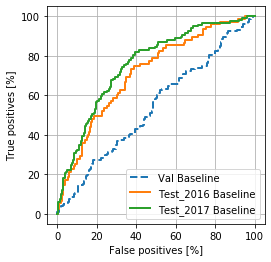

In [69]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_roc("Val Baseline", true_labels_val, predicted_labels_val, color=colors[0], linestyle='--')
plot_roc("Test_2016 Baseline", true_labels_test, predicted_labels_test, color=colors[1])
plot_roc("Test_2017 Baseline", true_labels_test_17, predicted_labels_test_17, color=colors[2])


plt.legend(loc='lower right')

dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


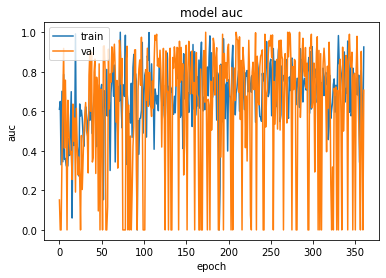

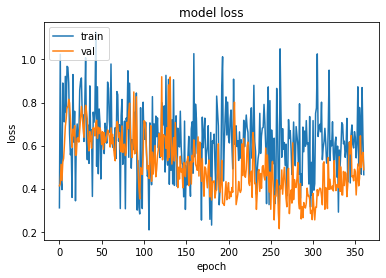

In [45]:
print(history.history.keys())
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()